In [2]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets.copy() 
  
# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 
  
# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 



{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC','CALC','MTRANS']
# One-hot encode categorical features, dropping the first category
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

# Convert X_encoded to a PyTorch tensor
X_tensor = torch.tensor(X_encoded.values, dtype=torch.float32)
X_tensor.shape

torch.Size([2111, 23])

In [5]:
y['NObeyesdad'] = y['NObeyesdad'].astype('category').cat.codes

# Convert to tensor
y_tensor = torch.tensor(y['NObeyesdad'].to_numpy(), dtype=torch.long)

In [6]:
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

In [7]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.zeros(output_dim)

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp() * np.sqrt(2 / self.output_dim))

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        # return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())
        return torch.distributions.StudentT(10, self.w_mu_q, torch.exp(0.5 * self.w_log_var_q))


    def q_b(self):
        """variational bias posterior"""
        # return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())
        return torch.distributions.StudentT(10, self.b_mu_q, torch.exp(0.5 * self.b_log_var_q))


    def kl(self,num_samples = 10):
        weight_samples = self.q_w().rsample((num_samples,))  # rsample allows for gradient propagation
        bias_samples = self.q_b().rsample((num_samples,))

        log_q_w = self.q_w().log_prob(weight_samples)  
        log_p_w = self.p_w().log_prob(weight_samples)

        log_q_b = self.q_b().log_prob(bias_samples)
        log_p_b = self.p_b().log_prob(bias_samples)

        weight_kl = (log_q_w - log_p_w).mean()  # Average over samples
        bias_kl = (log_q_b - log_p_b).mean()

        # weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        # bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).



class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        # activation=nn.LeakyReLU(negative_slope=0.01),
        activation=nn.ReLU(),
        noise_std=1.0,
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_covar = torch.eye(output_dim)*noise_std

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim)
                )
                self.network.append(torch.nn.Softmax(dim=2))

            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)

        # Propagate x through network
        for layer in self.network:
            x = layer(x)
        # x = torch.nn.Softmax(x,dim=1)
                
        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim
        return x
        # return x.squeeze(-1)

    def ll(self, y_obs, y_pred, num_samples=1):
        # """Computes the log likelihood of the outputs of self.forward(x) using a Bernoulli likelihood."""
        # print(y_pred.shape)
        # y_pred = y_pred.squeeze(0).squeeze(-1)
        # bernoulli = torch.distributions.Bernoulli(probs=y_pred)
        # ll_tensor = bernoulli.log_prob(y_obs).mean(0) 
        # return ll_tensor.squeeze()
        # """Computes the log likelihood of the outputs of self.forward(x)"""
        # l = torch.distributions.Categorical(probs=y_pred)
        # print(y_pred.shape)
        #  # take mean over num_samples dim, sum over batch_size dim
        # # note that after taking mean, batch_size becomes dim 0
        # return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1)).mean(0).sum(0).squeeze()
        #going to just write it in a way I know will work first.
        # print(y_pred.shape)



        # ll = torch.tensor([[0.0]])

        # for i, y in enumerate(y_pred.squeeze(0)):
        #     l = torch.distributions.Categorical(probs=y)
        #     ll += l.log_prob(y_obs[i].repeat(num_samples,1,1)).mean(0)
        # return ll.squeeze()
        l = torch.distributions.Categorical(probs=y_pred)
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()

    

    def kl(self, num_samples=10):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(num_samples) for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(num_samples = num_samples)
        return kl - exp_ll, exp_ll, kl

In [8]:
bnn_model = MeanFieldBNN(23, [10, 10], 7, noise_std=0.5)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): ReLU()
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ReLU()
    (2): MeanFieldLayer()
    (3): ReLU()
    (4): MeanFieldLayer()
    (5): Softmax(dim=2)
  )
)


100%|██████████| 4000/4000 [02:55<00:00, 22.74it/s]


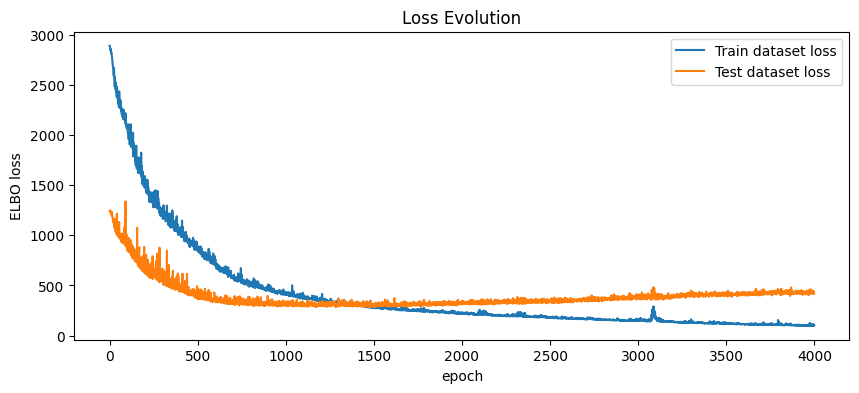

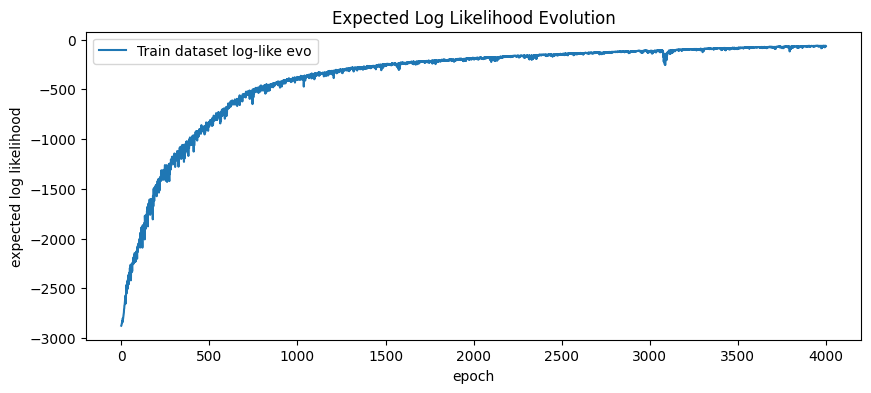

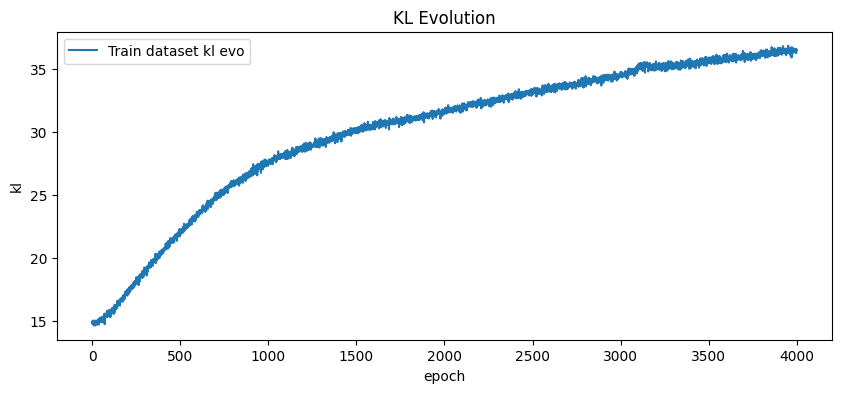

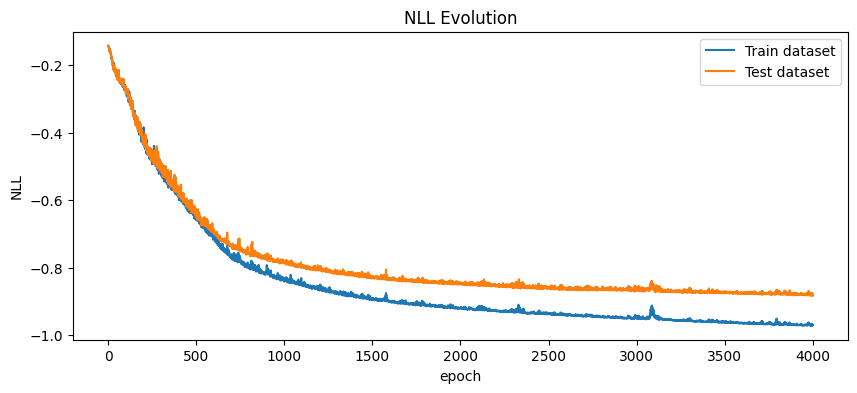

In [9]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_nll_loss_evo = []
te_nll_loss_evo = []
aux_loss = nn.NLLLoss()

for epoch in tqdm(range(4000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr, num_samples = 10)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_nll_loss_evo.append(aux_loss(bnn_model(x_tr,num_samples=10).mean(0), y_tr).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    te_nll_loss_evo.append(aux_loss(bnn_model(x_te,num_samples=10).mean(0), y_te).item())

    l.backward()
    opt.step()

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_nll_loss_evo, label='Train dataset')
plt.plot(te_nll_loss_evo, label='Test dataset')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.legend()
plt.title('NLL Evolution')
plt.show()

In [10]:
preds = bnn_model(x_te, num_samples=500)
mean_preds = preds.mean(0)
mean_preds.shape # might need numpy

torch.Size([634, 7])

In [11]:
loss = nn.NLLLoss()
loss(torch.log(mean_preds),y_te)

tensor(0.6259, grad_fn=<NllLossBackward0>)

In [18]:
y_te.shape

torch.Size([634])

In [19]:
mean_preds = mean_preds.detach().numpy()

In [20]:
df = pd.DataFrame(
    mean_preds,  # Each column will be one of the 7 confidence values
    columns=[f'confidence_{i}' for i in range(mean_preds.shape[1])]
)
df['true_label'] = y_te  # Add the true labels
df.to_csv('obesity_preds.csv', index=False)

In [21]:
df = pd.read_csv('obesity_preds.csv')
plot_name = 'calibration_data'


In [22]:
df_melted = df.melt(id_vars=["true_label"], 
                    value_vars=["confidence_0", "confidence_1", "confidence_2", "confidence_3", 
                                "confidence_4", "confidence_5", "confidence_6"], 
                    var_name="pred_label", value_name="confidence")

# Extract the numerical part of the pred_label
df_melted["pred_label"] = df_melted["pred_label"].str.extract("(\d+)").astype(int)

# Reorder the columns to match the desired format
df_final = df_melted[["pred_label", "true_label", "confidence"]]

In [23]:
y_true = df_final.true_label.values
y_pred = df_final.pred_label.values
y_conf = df_final.confidence.values

In [24]:
df

,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,confidence_6,true_label
0,0.141350,0.141310,0.144605,0.144944,0.145298,0.141027,0.141465,0
1,0.141116,0.140836,0.145175,0.145329,0.145781,0.140685,0.141078,4
2,0.141331,0.141261,0.144651,0.144987,0.145344,0.140997,0.141431,0
3,0.141391,0.141397,0.144499,0.144889,0.145212,0.141082,0.141530,0
4,0.141267,0.141147,0.144800,0.145077,0.145460,0.140914,0.141335,1
...,...,...,...,...,...,...,...,...
629,0.141298,0.141202,0.144725,0.145035,0.145402,0.140956,0.141382,5
630,0.141375,0.141362,0.144545,0.144909,0.145243,0.141064,0.141502,0
631,0.141298,0.141207,0.144726,0.145036,0.145397,0.140956,0.141381,5
632,0.141360,0.141324,0.144580,0.144934,0.145290,0.141032,0.141479,5


In [25]:
# Override matplotlib default styling.
# plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

In [26]:
def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins

    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.

    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.

    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float64)
    bin_confidences = np.zeros(num_bins, dtype=np.float64)
    bin_counts = np.zeros(num_bins, dtype=int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }

In [27]:
def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.

    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.

    The black line is the accuracy, the other end of the bar is the confidence.

    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.

    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.

    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


In [28]:
def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig

In [29]:
def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


In [30]:

def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])

/var/folders/d5/bt4mpp9n3gngv4q0rms4ylwm0000gn/T/ipykernel_83082/1827701276.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


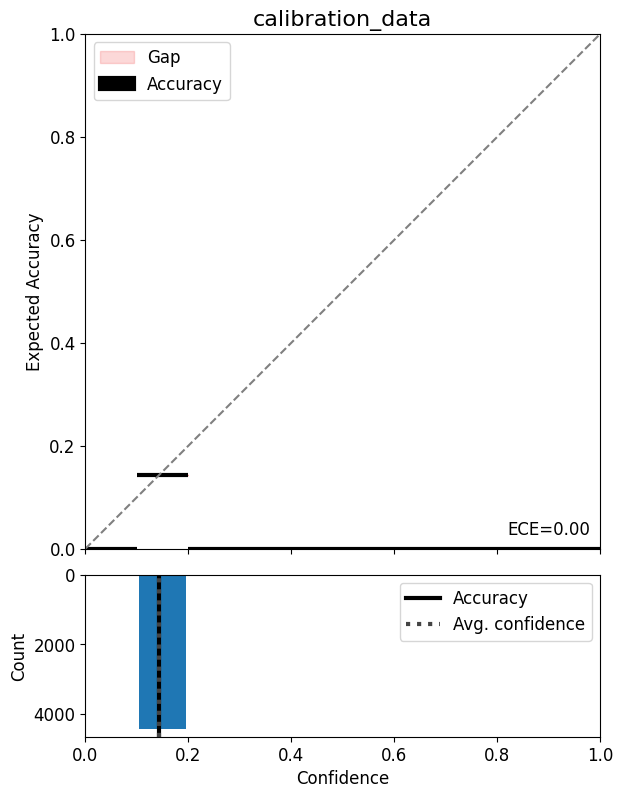

In [31]:
title = "\n".join(plot_name.split())

fig = reliability_diagram(y_true, y_pred, y_conf, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)

In [32]:
bin_data = compute_calibration(y_true, y_pred, y_conf, 10)
bin_data

{'accuracies': array([0.        , 0.14285714, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'confidences': array([0.        , 0.14285714, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'counts': array([   0, 4438,    0,    0,    0,    0,    0,    0,    0,    0]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': np.float64(0.14285714285714285),
 'avg_confidence': np.float64(0.14285714287967552),
 'expected_calibration_error': np.float64(2.2532670174157943e-11),
 'max_calibration_error': np.float64(2.2532670174157943e-11)}

In [33]:
bin_confs = bin_data['confidences']
bin_confs

array([0.        , 0.14285714, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [34]:
bin_accs = bin_data['accuracies']
bin_accs

array([0.        , 0.14285714, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

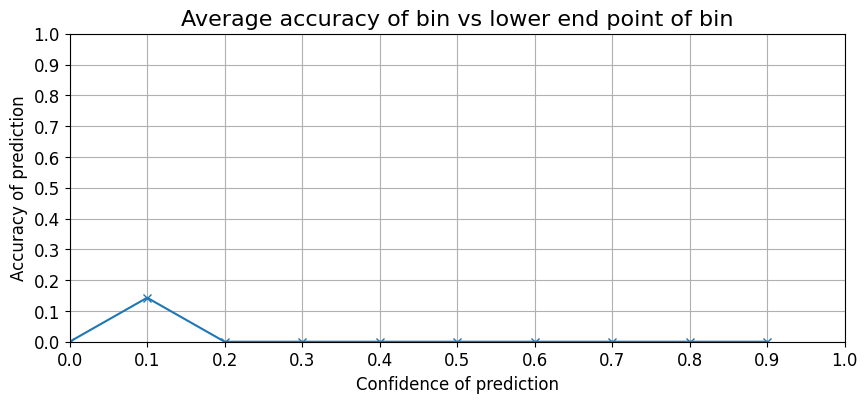

In [35]:
bin_vals = np.linspace(0, 1, 11)
plt.plot(bin_vals[0:10], bin_accs, marker = "x")
plt.xlim((0,1))
plt.ylim((0,1))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.xlabel("Confidence of prediction")
plt.ylabel("Accuracy of prediction")
plt.title("Average accuracy of bin vs lower end point of bin")
plt.show()


#not convinced that plotting at end points of the bins is correct

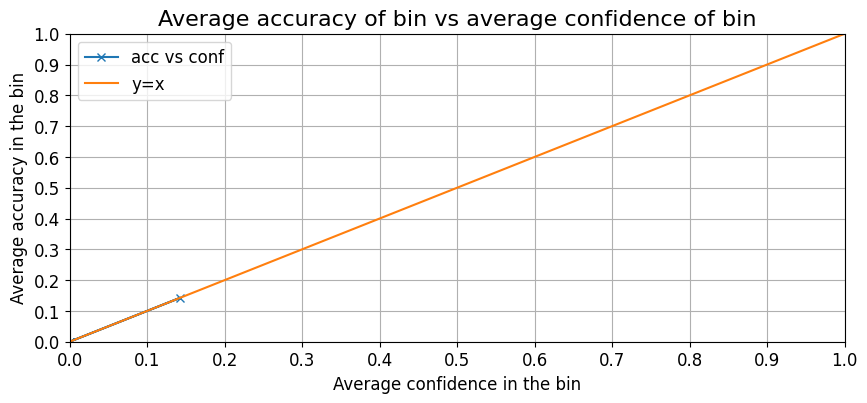

In [36]:
plt.plot(bin_confs, bin_accs, marker = "x", label = "acc vs conf")
plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), label = "y=x")
plt.xlim((0,1))
plt.ylim((0,1))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.xlabel("Average confidence in the bin")
plt.ylabel("Average accuracy in the bin")
plt.legend()
plt.title("Average accuracy of bin vs average confidence of bin")
plt.show()

#plotting average accuracy against average confidence lets us compare to y=x

In [37]:
bin_errors = bin_confs - bin_accs
bin_errors

array([0.00000000e+00, 2.25326702e-11, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

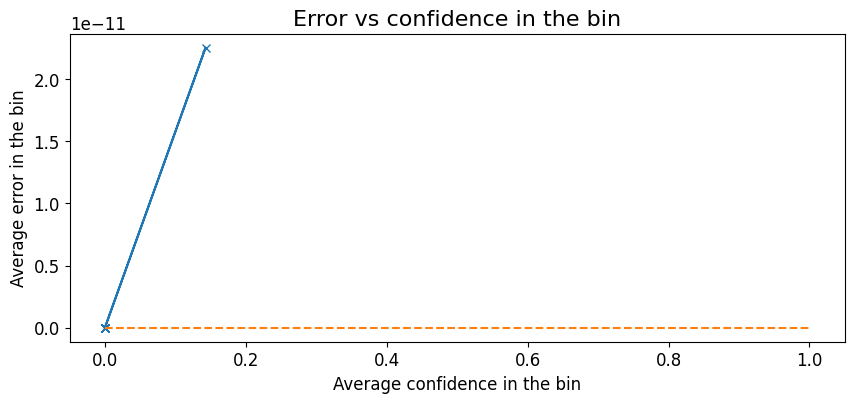

In [38]:
plt.plot(bin_confs, bin_errors, marker = "x")
plt.plot(np.array((0,1)), np.array((0,0)), "--")
plt.xlabel("Average confidence in the bin")
plt.ylabel("Average error in the bin")
plt.title("Error vs confidence in the bin")
plt.show()

In [13]:
max_preds = torch.argmax(mean_preds, dim=1)

# Calculate the percentage of correct predictions
correct_predictions = torch.sum(max_preds == y_te)
percentage_correct = (correct_predictions.item() / len(y_te)) * 100

print(f"Accuracy: {percentage_correct}%")
print(f"Percentage Error: {100 - percentage_correct}%")

Accuracy: 89.27444794952682%
Percentage Error: 10.725552050473183%


In [12]:
loss = nn.NLLLoss()
loss(torch.log(mean_preds),y_te)

tensor(0.6259, grad_fn=<NllLossBackward0>)

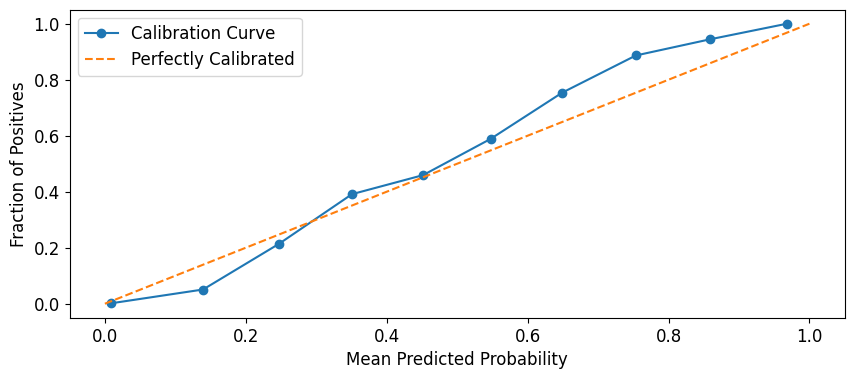

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_conf, y_te):
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(y_te, y_conf , n_bins=10)

    # Plot calibration curve
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.show()

# Example usage:
# mean_preds is the output of your model (probabilities for each class)
# y_te is the true labels
plot_calibration_curve(y_conf,y_true==y_pred)

In [ ]:
import pickle

# Save the data to a file
with open('calibration_data_mfvi.pkl', 'wb') as f:
    pickle.dump((y_conf, y_true == y_pred), f)


In [ ]:
import torch
import numpy as np

def adaptive_calibration_error(mean_preds, y_te, num_bins=10):
    """
    Compute the Adaptive Calibration Error (ACE) for a classification task.
    
    Parameters:
    - mean_preds (torch.Tensor): Tensor of predicted probabilities with shape (N, C),
                                  where N is the number of samples and C is the number of classes.
    - y_te (torch.Tensor): Tensor of true labels with shape (N,) where N is the number of samples.
    - num_bins (int): The number of bins to use for calibration. Default is 10.
    
    Returns:
    - ace (float): The Adaptive Calibration Error (ACE).
    """
    # Get predicted probabilities for the correct class
    predicted_probs = mean_preds.gather(1, y_te.view(-1, 1))  # (N, 1) tensor of probabilities for the correct class
    
    # Flatten the tensor
    predicted_probs = predicted_probs.view(-1)
    
    # Create bins for predicted probabilities
    bins = torch.linspace(0, 1, num_bins + 1)
    bin_indices = torch.bucketize(predicted_probs, bins) - 1  # Map probabilities to bin indices
    
    ace = 0
    for bin_idx in range(num_bins):
        # Get the indices of samples falling in this bin
        bin_mask = bin_indices == bin_idx
        bin_preds = predicted_probs[bin_mask]
        bin_labels = y_te[bin_mask]
        
        if bin_preds.numel() == 0:
            continue
        
        # Compute the observed accuracy within this bin
        observed_accuracy = (bin_preds == bin_labels.float()).float().mean().item()
        
        # Compute the expected accuracy (mean of bin_preds)
        expected_accuracy = bin_preds.mean().item()
        
        # Compute the absolute difference between observed and expected accuracy
        ace += abs(observed_accuracy - expected_accuracy)
    
    ace /= num_bins  # Average over all bins
    return ace



# Compute ACE
ace = adaptive_calibration_error(mean_preds, y_te)
print(f"Adaptive Calibration Error: {ace}")


Adaptive Calibration Error: 0.5047484043985605


In [ ]:
import torch
import numpy as np

def static_calibration_error(mean_preds, y_te, num_bins=10):
    """
    Compute the Static Calibration Error (SCE) for a classification task.
    
    Parameters:
    - mean_preds (torch.Tensor): Tensor of predicted probabilities with shape (N, C),
                                  where N is the number of samples and C is the number of classes.
    - y_te (torch.Tensor): Tensor of true labels with shape (N,) where N is the number of samples.
    - num_bins (int): The number of bins to use for calibration. Default is 10.
    
    Returns:
    - sce (float): The Static Calibration Error (SCE).
    """
    # Get predicted probabilities for the correct class
    predicted_probs = mean_preds.gather(1, y_te.view(-1, 1))  # (N, 1) tensor of probabilities for the correct class
    
    # Flatten the tensor
    predicted_probs = predicted_probs.view(-1)
    
    # Create bins for predicted probabilities
    bins = torch.linspace(0, 1, num_bins + 1)
    bin_indices = torch.bucketize(predicted_probs, bins) - 1  # Map probabilities to bin indices
    
    sce = 0
    for bin_idx in range(num_bins):
        # Get the indices of samples falling in this bin
        bin_mask = bin_indices == bin_idx
        bin_preds = predicted_probs[bin_mask]
        bin_labels = y_te[bin_mask]
        
        if bin_preds.numel() == 0:
            continue
        
        # Compute the observed accuracy within this bin
        observed_accuracy = (bin_preds == bin_labels.float()).float().mean().item()
        
        # Compute the expected accuracy (mean of bin_preds)
        expected_accuracy = bin_preds.mean().item()
        
        # Compute the absolute difference between observed and expected accuracy
        sce += abs(observed_accuracy - expected_accuracy)
    
    sce /= num_bins  # Average over all bins
    return sce

# Example usage
# mean_preds is a tensor of shape (N, C), y_te is a tensor of shape (N,)
# Example: 640 samples, 7 classes
mean_preds = torch.randn(640, 7).softmax(dim=1)  # Example probabilities from a softmax output
y_te = torch.randint(0, 7, (640,))  # Example true labels (integers from 0 to 6)

# Compute SCE
sce = static_calibration_error(mean_preds, y_te)
print(f"Static Calibration Error: {sce}")


Static Calibration Error: 0.39632403329014776
